# Harmony Concatenation Tutorial

## Before you start

Before you beginning this tutorial, make sure you have an account in the Earthdata Login UAT or Production environment, which will be used for this notebook by visiting https://uat.urs.earthdata.nasa.gov. These accounts, as all Earthdata Login accounts, are free to create and only take a moment to set up.

## Set Up Authentication

We need some boilerplate up front to log in to Earthdata Login. The function below will allow Python scripts to log into any Earthdata Login application programmatically. To avoid being prompted for credentials every time you run and also allow clients such as curl to log in, you can add the following to a .netrc (_netrc on Windows) file in your home directory:

machine uat.urs.earthdata.nasa.gov
    login <your username>
    password <your password>

machine urs.earthdata.nasa.gov
    login <your username>
    password <your password>
Make sure that this file is only readable by the current user or you will receive an error stating "netrc access too permissive."

`$ chmod 0600 ~/.netrc`

In [1]:
from urllib import request
from http.cookiejar import CookieJar
import getpass
import netrc
import json
import requests
import sys
import time
import shutil
import xarray as xr
import matplotlib.pyplot as plt
from urllib.parse import urljoin, urlencode
import math

import warnings
warnings.filterwarnings('ignore')

Define a helper function for retrieving Earthdata Login credentials. 

In [2]:
def setup_earthdata_login_auth(endpoint):
    """
    Set up the request library so that it authenticates against the given Earthdata Login
    endpoint and is able to track cookies between requests.  This looks in the .netrc file 
    first and if no credentials are found, it prompts for them.

    Valid endpoints include:
        uat.urs.earthdata.nasa.gov - Earthdata Login UAT (Harmony's current default)
        urs.earthdata.nasa.gov - Earthdata Login production
    """
    try:
        username, _, password = netrc.netrc().authenticators(endpoint)
    except (FileNotFoundError, TypeError):
        # FileNotFound = There's no .netrc file
        # TypeError = The endpoint isn't in the netrc file, causing the above to try unpacking None
        print('Please provide your Earthdata Login credentials to allow data access')
        print('Your credentials will only be passed to %s and will not be exposed in Jupyter' % (endpoint))
        username = input('Username:')
        password = getpass.getpass()

    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, endpoint, username, password)
    auth = request.HTTPBasicAuthHandler(manager)

    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)

Define endpoints to be used for this tutorial. These will be different if `uat` vs `ops` is selected as the venue.

In [3]:
venue = 'uat'

if venue == 'uat':
    cmr_root = 'cmr.uat.earthdata.nasa.gov'
    harmony_root = 'https://harmony.uat.earthdata.nasa.gov'
    edl_root = 'uat.urs.earthdata.nasa.gov'
elif venue == 'ops':
    cmr_root = 'cmr.earthdata.nasa.gov'
    harmony_root = 'https://harmony.earthdata.nasa.gov'
    edl_root = 'urs.earthdata.nasa.gov'  

Setup EDL login credentials. These will be used later in the Harmony request

In [4]:
setup_earthdata_login_auth(edl_root)

Define the following:

- `collection_id`: Used in the Harmony concatenation request. This should be the CMR concept ID we want to concatenate
- `max_results`: The number of granules we want to concatenate together

In [5]:
collection_id = 'C1238657959-POCLOUD'  # ASCATB-L2-25km
max_results = 5

Construct the Harmony concatenation request. The Harmony request should contain `concatenate=true` in order to reach the concatenation service.

In [6]:
concat_harmony_url = urljoin(
    harmony_root, 
    f'{collection_id}/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset'#?concatenate=true&maxResults=2&turbo=true'
)

query_params = {
    'concatenate': 'true',
    'maxResults': max_results,
    'turbo': 'true'
}

concat_harmony_url = f'{concat_harmony_url}?{urlencode(query_params)}'
print(concat_harmony_url)

https://harmony.uat.earthdata.nasa.gov/C1238657959-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?concatenate=true&maxResults=5&turbo=true


Execute the HTTP request. The response is a redirect to the Harmony `/jobs` endpoint, which returns information about the running job.

In [7]:
response = requests.get(concat_harmony_url, allow_redirects=True)
job_url = response.url
response = response.json()
print(json.dumps(response, indent=2))

{
  "username": "skperez",
  "status": "running",
  "message": "CMR query identified 455 granules, but the request has been limited to process only the first 5 granules because you requested 5 maxResults.",
  "progress": 0,
  "createdAt": "2021-12-02T00:38:41.606Z",
  "updatedAt": "2021-12-02T00:38:41.606Z",
  "links": [
    {
      "href": "https://harmony.uat.earthdata.nasa.gov/jobs/6b49e225-33c3-4af8-a9cd-6b236e522fdc?page=1&limit=2000",
      "title": "The current page",
      "type": "application/json",
      "rel": "self"
    }
  ],
  "request": "https://harmony.uat.earthdata.nasa.gov/C1238657959-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?concatenate=true&maxResults=5&turbo=true",
  "numInputGranules": 5,
  "jobID": "6b49e225-33c3-4af8-a9cd-6b236e522fdc"
}


Wait until the harmony job is completed. The Harmony `/jobs` endpoint should be repeatedly  queryied until the job status indicates success.

In [8]:
while response['status'] == 'running':
    response = requests.get(job_url)
    response = response.json()
    time.sleep(1)

Retrieve the download url from the Harmony job

In [9]:
result_download_url = list(filter(lambda link: link['rel'] == 'data', response['links']))[-1]['href']
result_download_url

'https://harmony.uat.earthdata.nasa.gov/service-results/harmony-uat-staging/public/podaac/concise/53cea5c0-f41b-4b2e-832f-c51edd27f60c/C1238657959-POCLOUD_merged.nc4'

Write Harmony output to local file `concat_granule.nc`

In [10]:
with open('concat_granule.nc', 'wb') as out_file:
    content = requests.get(result_download_url, stream=True).content
    out_file.write(content)

Open Harmony Concise output in xarray

In [11]:
ds = xr.open_dataset('concat_granule.nc', decode_times=False)
ds

<xarray.Dataset>
Dimensions:           (subset_index: 5, NUMROWS: 1632, NUMCELLS: 42)
Coordinates:
    lat               (subset_index, NUMROWS, NUMCELLS) float32 ...
    lon               (subset_index, NUMROWS, NUMCELLS) float32 ...
Dimensions without coordinates: subset_index, NUMROWS, NUMCELLS
Data variables:
    subset_files      (subset_index) object ...
    time              (subset_index, NUMROWS, NUMCELLS) float32 ...
    wvc_index         (subset_index, NUMROWS, NUMCELLS) float32 ...
    model_speed       (subset_index, NUMROWS, NUMCELLS) float32 ...
    model_dir         (subset_index, NUMROWS, NUMCELLS) float32 ...
    ice_prob          (subset_index, NUMROWS, NUMCELLS) float32 ...
    ice_age           (subset_index, NUMROWS, NUMCELLS) float32 ...
    wvc_quality_flag  (subset_index, NUMROWS, NUMCELLS) float64 ...
    wind_speed        (subset_index, NUMROWS, NUMCELLS) float32 ...
    wind_dir          (subset_index, NUMROWS, NUMCELLS) float32 ...
    bs_distance       (subset_index, NUMROWS, NUMCELLS) float32 ...
Attributes: (12/23)
    title:                            MetOp-B ASCAT Level 2 25.0 km Ocean Sur...
    title_short_name:                 ASCATB-L2-25km
    Conventions:                      CF-1.6
    institution:                      EUMETSAT/OSI SAF/KNMI
    source:                           MetOp-B ASCAT
    software_identification_level_1:  1000
    ...                               ...
    orbit_inclination:                98.7
    history:                          N/A
    references:                       ASCAT Wind Product User Manual, http://...
    comment:                          Orbit period and inclination are consta...
    creation_date:                    2020-01-01
    history_json:                     [{"date_time": "2021-12-02T00:38:50.081...

The number of results we requested in the Harmony Concise request should be equal to the size of the `subset_index` dimension.

In [12]:
assert len(ds.coords['subset_index']) == max_results

Plot `wind_speed` from each individual granule, where `subset_index=0`, `subset_index=1`, ... etc

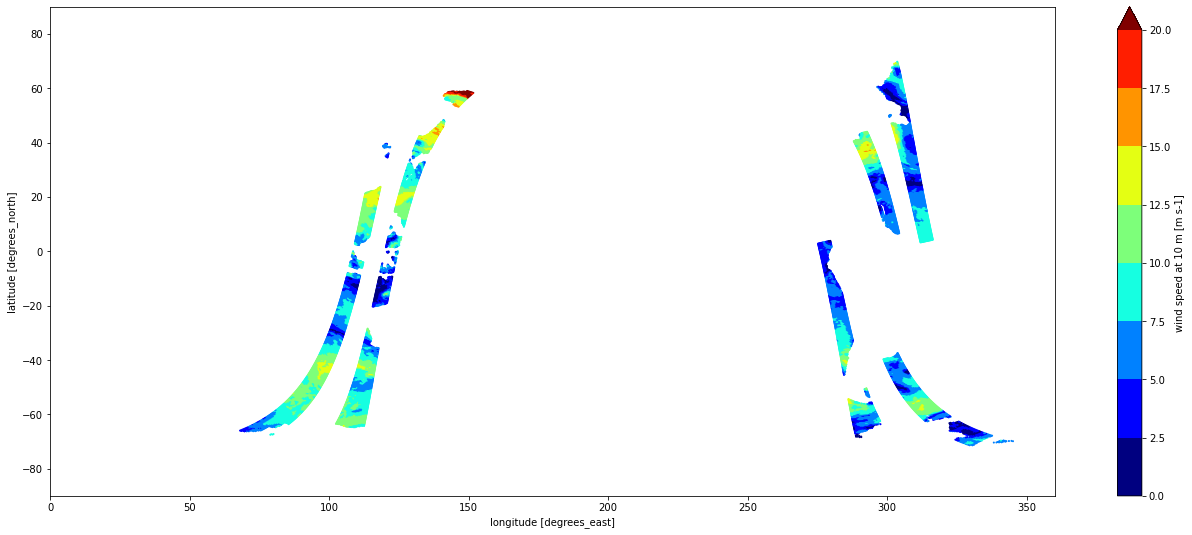

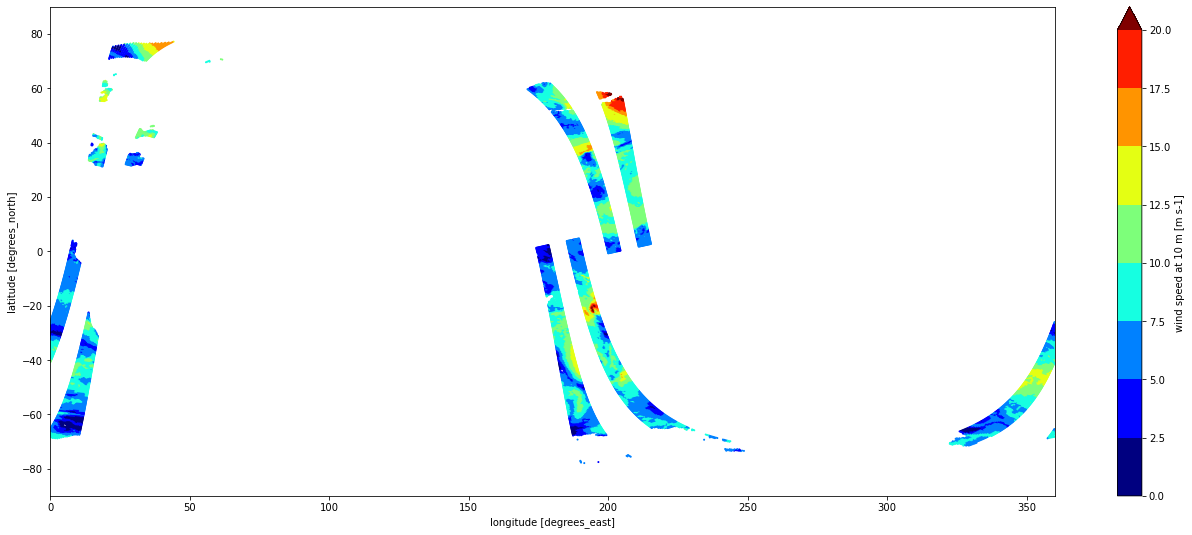

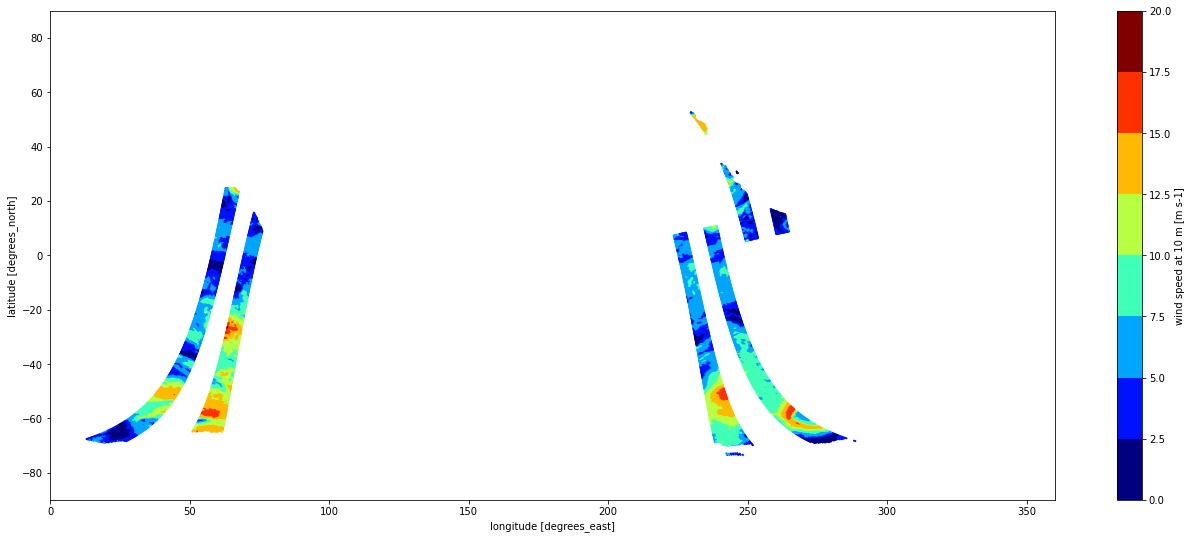

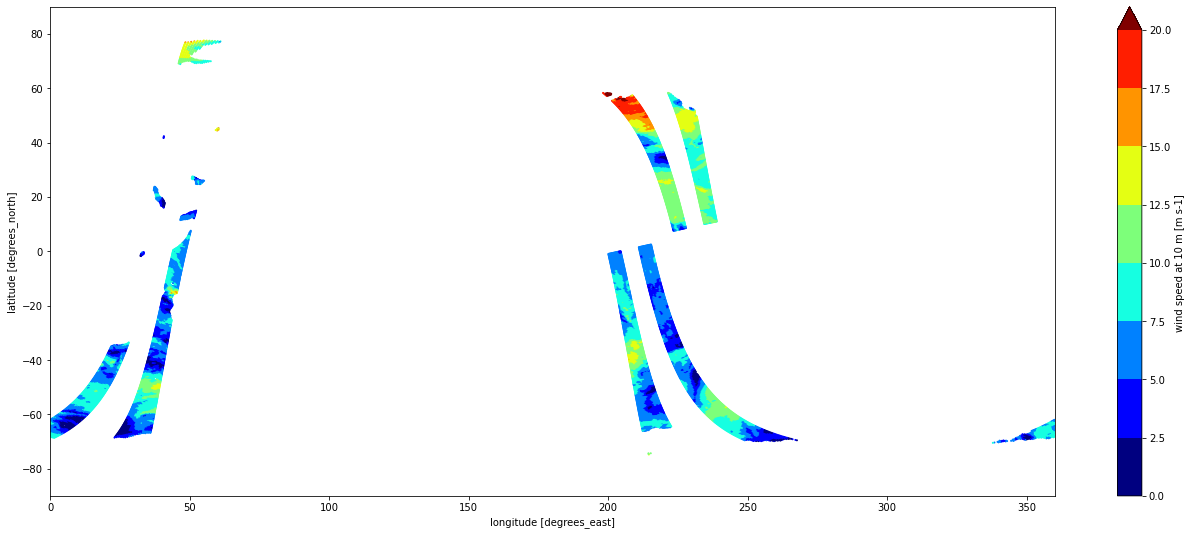

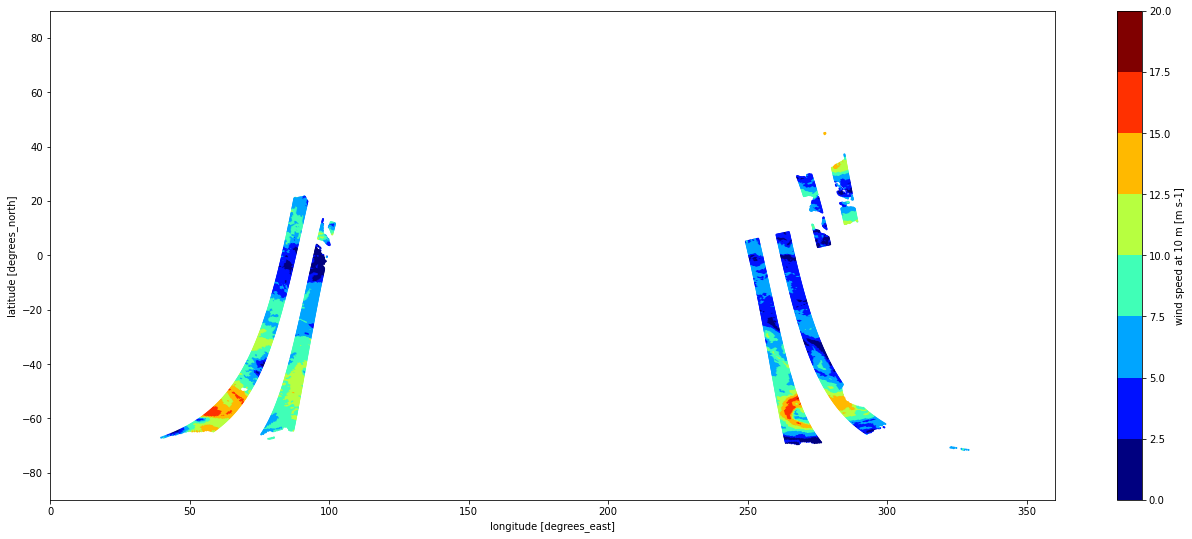

In [13]:
for index in range(0, max_results):   
    ds.isel(subset_index=index).plot.scatter(
        y="lat",
        x="lon",
        hue="wind_speed",
        s=1,
        vmin=0.0,
        vmax=20.0,
        levels=9,
        cmap="jet",
        aspect=2.5,
        size=9
    )

    plt.xlim(  0., 360.)
    plt.ylim(-90.,  90.)
    plt.show()

Plot `wind_speed` for the entire granule. You can see that multiple granules have been combined into a single granule in this plot.